The stakeholder ist Amy Williams. Sie is a Mafiosi Seller of several central houses(top10%) over time, she needs average outskirt houses over time to hide from the FBI. I assume she has those already and doenst need to buy those.

I derive two needs: 
Sell central top houses for profit over the year
Keep average outskirt houses for safety by density

In [2]:
# Install Modules
!pip install scikit-learn

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.ensemble import RandomForestRegressor  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


In [3]:
# Load Data
#file_path = 'data/King_County_House_prices_dataset.csv'  
data = pd.read_csv('data/King_County_House_prices_dataset.csv')

1. take a look at the data

2.  clean the data
-   Date Parsing: Converted the date column to a datetime format to enable seasonal analysis (by extracting the year and month).
-   Density Calculations: Created a density_score to approximate density using sqft_living15 (average living space of 15 surrounding homes) and sqft_lot15 (average lot size of 15 surrounding properties).
-   Formula: density_score = sqft_living15 / sqft_lot15. A higher density_score indicates a denser (more central) area.
3.  treat NuN
-   in this case we can change all NuN to 0, since they only appear in categories that are not to be calculated with.

In [21]:
# take a look at data
data.head(), data.columns

(           id        date     price  bedrooms  bathrooms  sqft_living  \
 0  7129300520  10/13/2014  221900.0         3       1.00         1180   
 1  6414100192   12/9/2014  538000.0         3       2.25         2570   
 2  5631500400   2/25/2015  180000.0         2       1.00          770   
 3  2487200875   12/9/2014  604000.0         4       3.00         1960   
 4  1954400510   2/18/2015  510000.0         3       2.00         1680   
 
    sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
 0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
 1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
 2     10000     1.0         0.0   0.0  ...      6         770            0.0   
 3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
 4      8080     1.0         0.0   0.0  ...      8        1680            0.0   
 
   yr_built  yr_renovated  zipcode      lat     long  sqft_living1

In [4]:
# take a look at the data
# parse Date from the columns date according to purpose
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['year'] = data['date'].dt.year 
# check, did it work?

<Axes: >

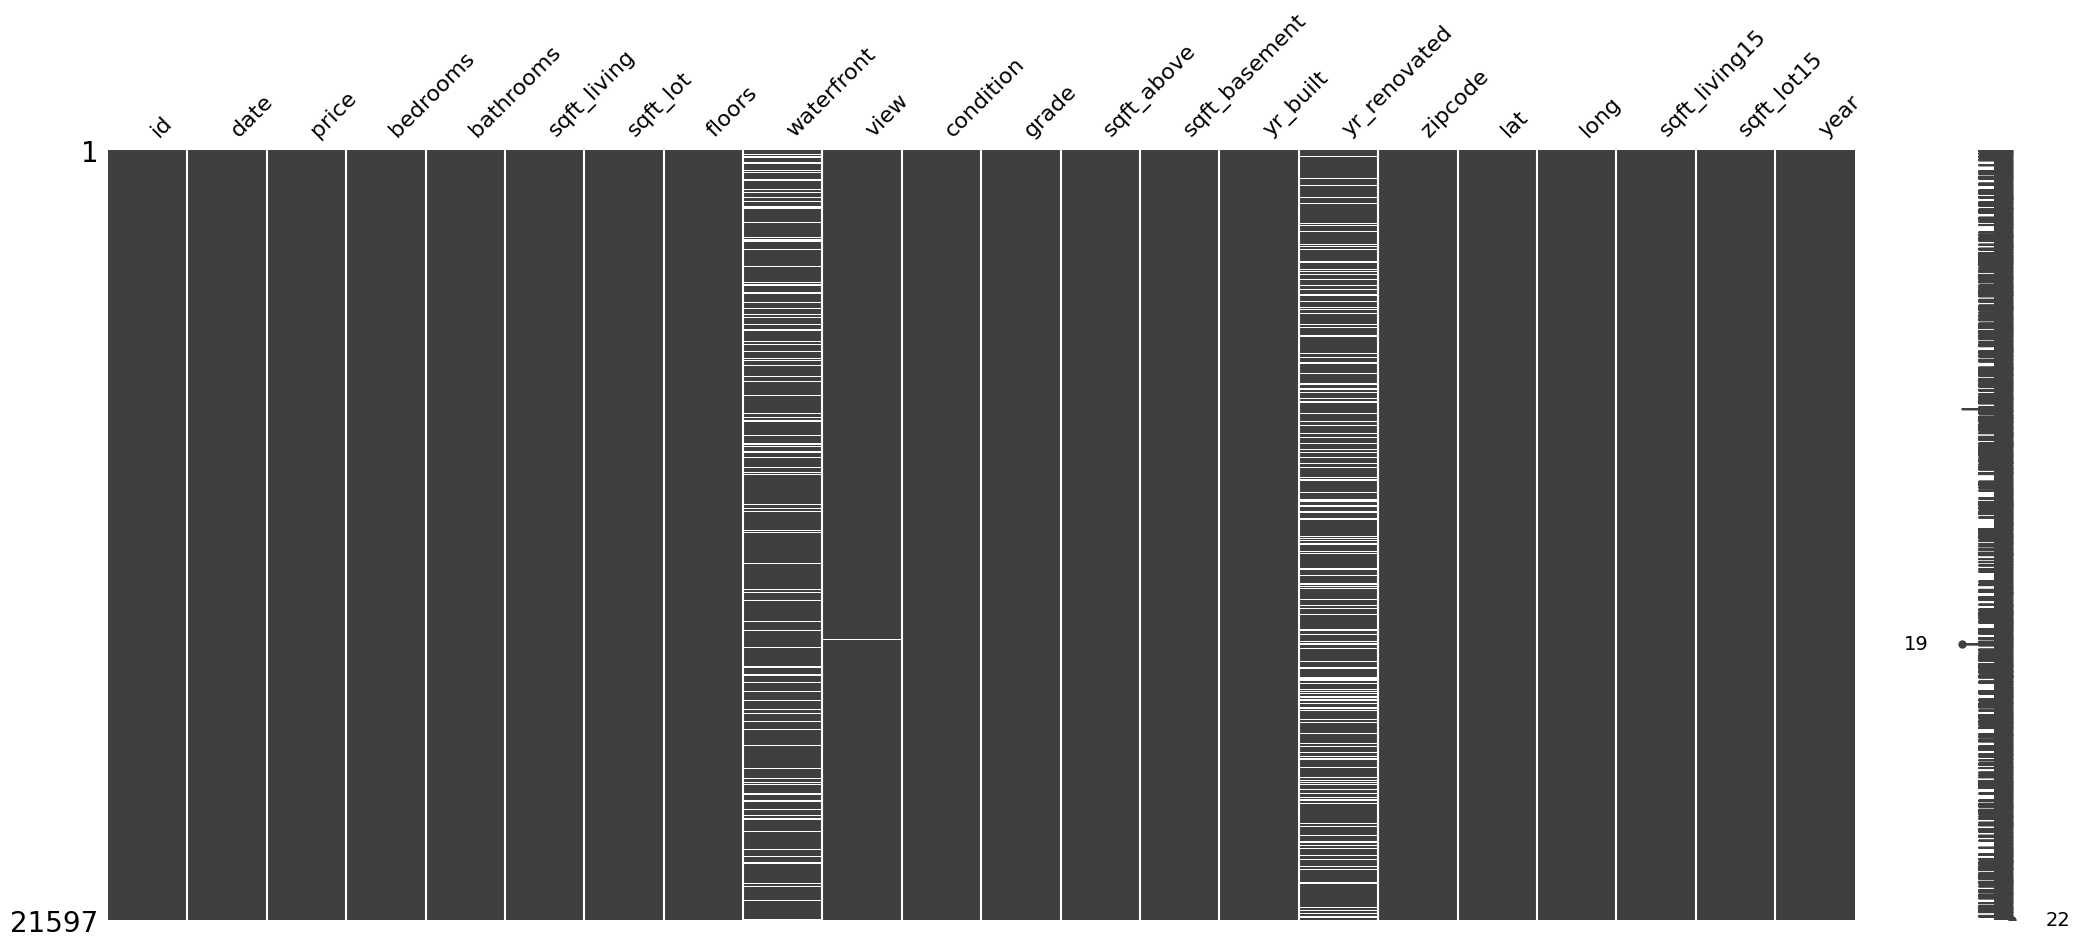

In [5]:
# treat NuN
# checking for missing data
import missingno as msno
data.isna().sum()
msno.matrix(data) 
# there are missing Data in waterfront, view, and yr_renovated - I assume the missing data indicate there is no information: no waterfront, no view or no renovation. Filling those Nun with 0 will not change any calculations 


<Axes: >

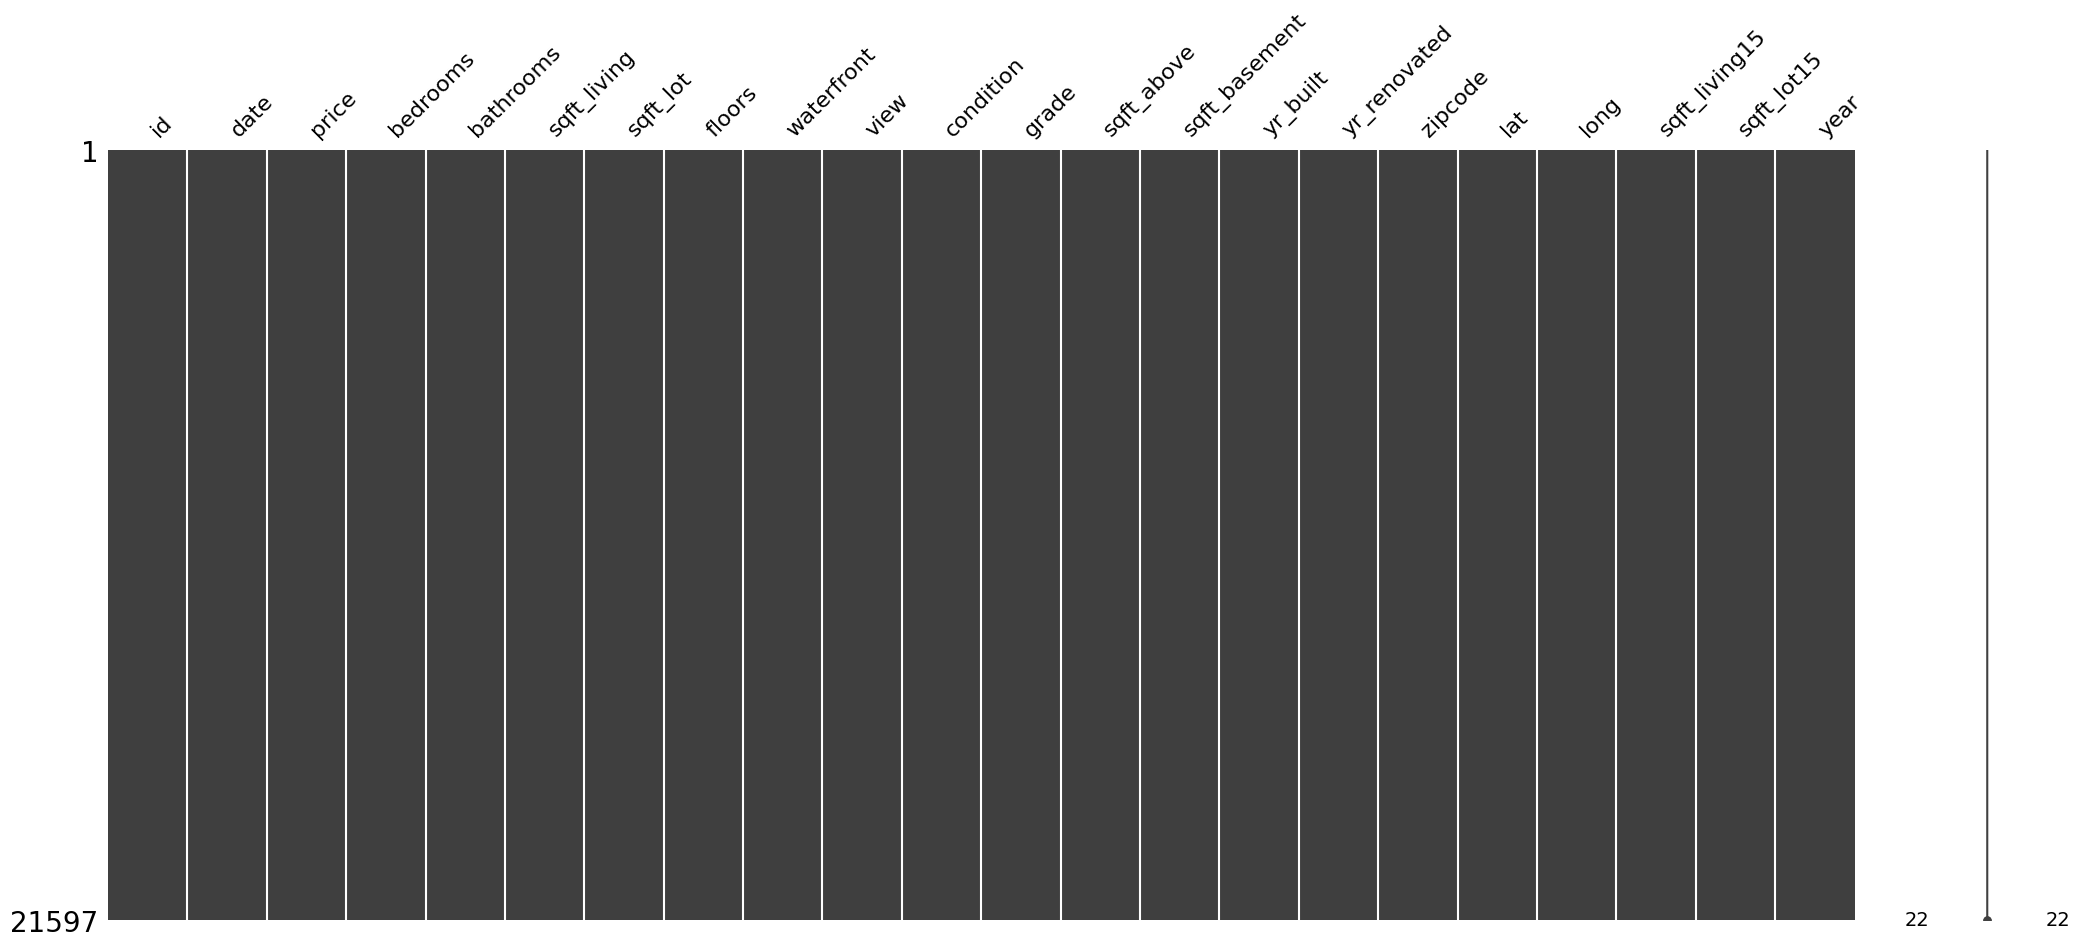

In [6]:
#Fill the Nun will the value 0
dfc = data.copy() # safetycopy

data.fillna(0, inplace=True)
data.reset_index(inplace=True, drop=True)
msno.matrix(data)

I look for seasonal effects on property prices.
For better comparison I chose to analyse properties grouped in three categories.
Even though the size of the property has a bigger influence on the price, I decides to filter for a factor, that ist better to handle for customers - that is number of rooms

/tmp/ipykernel_3824/1826914759.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg_price_by_type = data.groupby(['month', 'property_type'])['price'].mean().unstack()


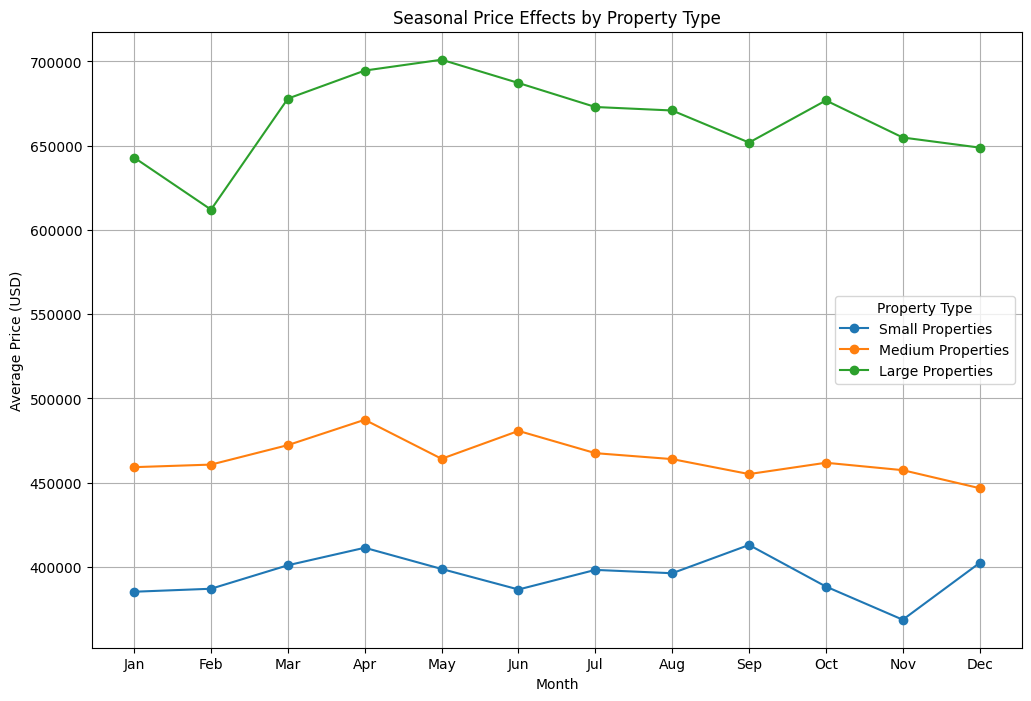

In [8]:
# Define property types based on bedroom count
# We'll categorize properties as follows:
# - Small (1-2 bedrooms)
# - Medium (3 bedrooms)
# - Large (4+ bedrooms)

data['property_type'] = pd.cut(data['bedrooms'], bins=[0, 2, 3, float('inf')], labels=['Small', 'Medium', 'Large'])

# Calculate the monthly average price for each property type
monthly_avg_price_by_type = data.groupby(['month', 'property_type'])['price'].mean().unstack()

# Plotting monthly average price trends by property type to observe seasonal effects
plt.figure(figsize=(12, 8))
for property_type in monthly_avg_price_by_type.columns:
    plt.plot(monthly_avg_price_by_type.index, monthly_avg_price_by_type[property_type], marker='o', linestyle='-', 
             label=f"{property_type} Properties")

plt.title("Seasonal Price Effects by Property Type")
plt.xlabel("Month")
plt.ylabel("Average Price (USD)")
plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Property Type")
plt.grid(True)
plt.show()


Finding high and low density areas in Seattle

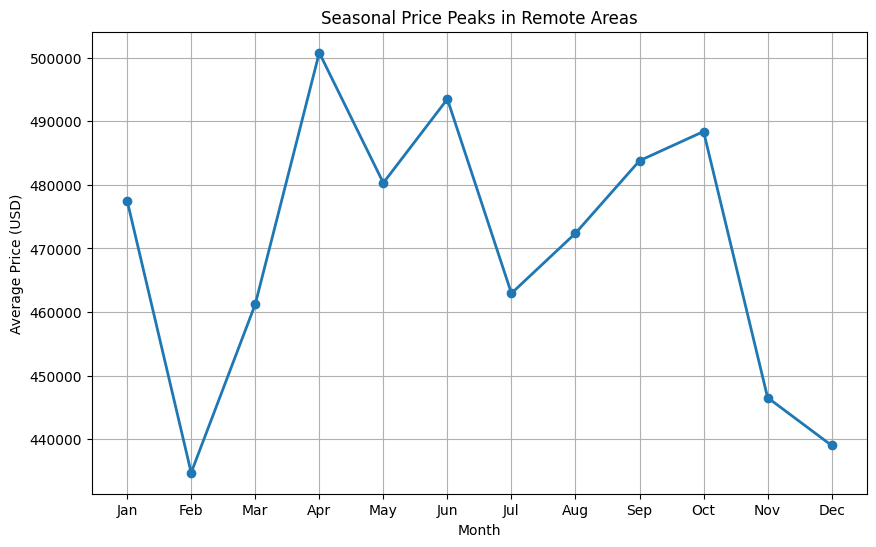

AttributeError: 'DataFrameGroupBy' object has no attribute 'info'

In [40]:
# Calculate density score based on surrounding living area and lot size so the bigger the score, the higher the density. Maximum is 1.
data['density_score'] = data['sqft_living15'] / data['sqft_lot15']

# Define central and remote areas based on density score thresholds
central_threshold = data['density_score'].quantile(0.75)
remote_threshold = data['density_score'].quantile(0.25)
data['area_type'] = data['density_score'].apply(lambda x: 'Central' if x >= central_threshold else ('Remote' if x <= remote_threshold else 'Intermediate'))

data['area_type']

# Calculate the average price for suburban properties by month
suburban_properties = data[data['area_type'] == 'Remote']
monthly_avg_price_suburbs = suburban_properties.groupby('month')['price'].mean()

# Plotting the monthly average prices for suburban properties to identify seasonal price peaks
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_price_suburbs.index, monthly_avg_price_suburbs.values, marker='o', linestyle='-', linewidth=2)
plt.title("Seasonal Price Peaks in Remote Areas")
plt.xlabel("Month")
plt.ylabel("Average Price (USD)")
plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()



In [45]:
# finding zip codes of those remote areas
rem_zip = suburban_properties.groupby('zipcode').count()
rem_zip

TypeError: GroupBy.count() takes 1 positional argument but 2 were given

My Recomendation is to keep properties that are in the zipcodes in rem_zip.
Optionally you can search for most avg. properties like 

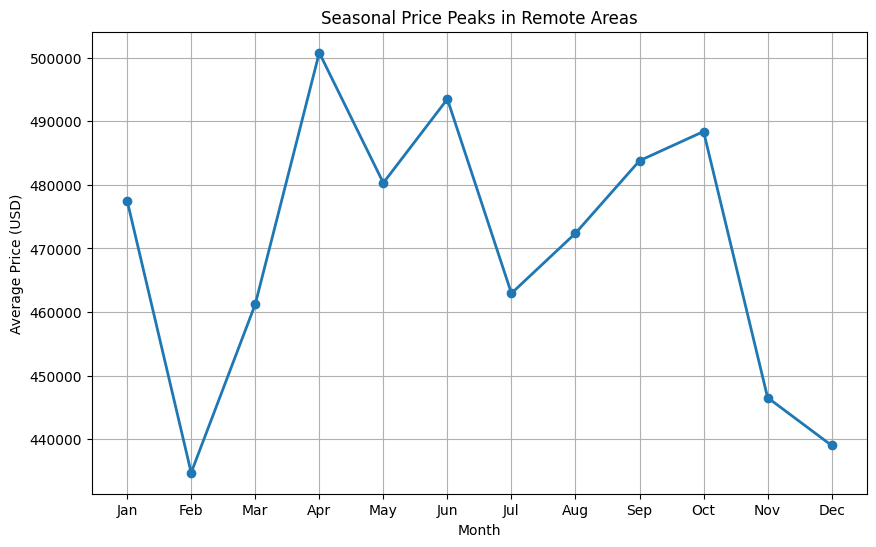

In [34]:


# Finding the peak month(s) with the highest average price for suburban areas - we dont need that here, but we will for central areas!
#suburb_peak_month = monthly_avg_price_suburbs.idxmax()
#suburb_peak_month_price = monthly_avg_price_suburbs.max()
#suburb_low_month = monthly_avg_price_suburbs.idxmin()
#suburb_low_month_price = monthly_avg_price_suburbs.min()
#suburb_peak_month, suburb_peak_month_price, suburb_low_month, suburb_low_month_price


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,lat,long,sqft_living15,sqft_lot15,year,month,property_type,density_score,area_type
zipcode,,,,,,,,,,,,,,,,,,,,,
98001,162,162,162,162,162,162,162,162,162,162,...,162,162,162,162,162,162,162,162,162,162
98002,82,82,82,82,82,82,82,82,82,82,...,82,82,82,82,82,82,82,82,82,82
98003,92,92,92,92,92,92,92,92,92,92,...,92,92,92,92,92,92,92,92,92,92
98004,63,63,63,63,63,63,63,63,63,63,...,63,63,63,63,63,63,63,63,63,63
98005,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98177,57,57,57,57,57,57,57,57,57,57,...,57,57,57,57,57,57,57,57,57,57
98178,81,81,81,81,81,81,81,81,81,81,...,81,81,81,81,81,81,81,81,81,81
98188,85,85,85,85,85,85,85,85,85,85,...,85,85,85,85,85,85,85,85,85,85


The graph returns the highest price in average was in Month 4 / April, while the peak price in April was 500783.2373540856 
The graph returns the lowest price in average was in Month 2 / February, while the peak price in Feb was 434741.593442623


In [41]:
# 7. Identifying Central and Remote Properties for Recommendations

# Step 1: Filter for central properties in the top 10% by price
central_properties = data[data['area_type'] == 'Central']
central_top_10_threshold = central_properties['price'].quantile(0.9)
central_top_10_properties = central_properties[central_properties['price'] >= central_top_10_threshold]

# Step 2: Identify high-value zip codes in central areas for focused selling recommendations
high_value_central_zipcodes = central_top_10_properties.groupby('zipcode')['price'].mean().nlargest(5)
recommended_month = "June"  # Based on earlier findings for central area seasonality
print("Recommended Zip Codes for High-Value Central to Sell:")
print(high_value_central_zipcodes)

Recommended Zip Codes for High-Value Central to sell:
zipcode
98056    2.106667e+06
98125    2.050000e+06
98102    1.630106e+06
98112    1.548631e+06
98033    1.502778e+06
Name: price, dtype: float64


In [40]:
# Identifying Remote Properties for Quiet Areas

# Step 1: Define remote areas using the previously identified remote properties
remote_area_properties = data[data['area_type'] == 'Remote']

# Step 2: Filter for properties around the median price within remote areas
remote_median_price = remote_area_properties['price'].median()
avg_remote_properties = remote_area_properties[
    (remote_area_properties['price'] >= remote_median_price * 0.9) & 
    (remote_area_properties['price'] <= remote_median_price * 1.1)
]
recommended_remote_zipcodes = avg_remote_properties['zipcode'].value_counts().nlargest(5)
print("Recommended Zip Codes for Average-Priced Remote Properties to Keep:")
print(recommended_remote_zipcodes)


Recommended Zip Codes for Average-Priced Remote Properties to keep:
zipcode
98155    64
98042    37
98059    36
98072    33
98034    32
Name: count, dtype: int64


After those two recommendations one might have a look at a map containing the info - this could be another task for future work

Lets take a look at the most easy to grasp as well as relevant factors: Number of bedrooms

/tmp/ipykernel_3824/3955508916.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg_price_by_type = data.groupby(['month', 'property_type'])['price'].mean().unstack()


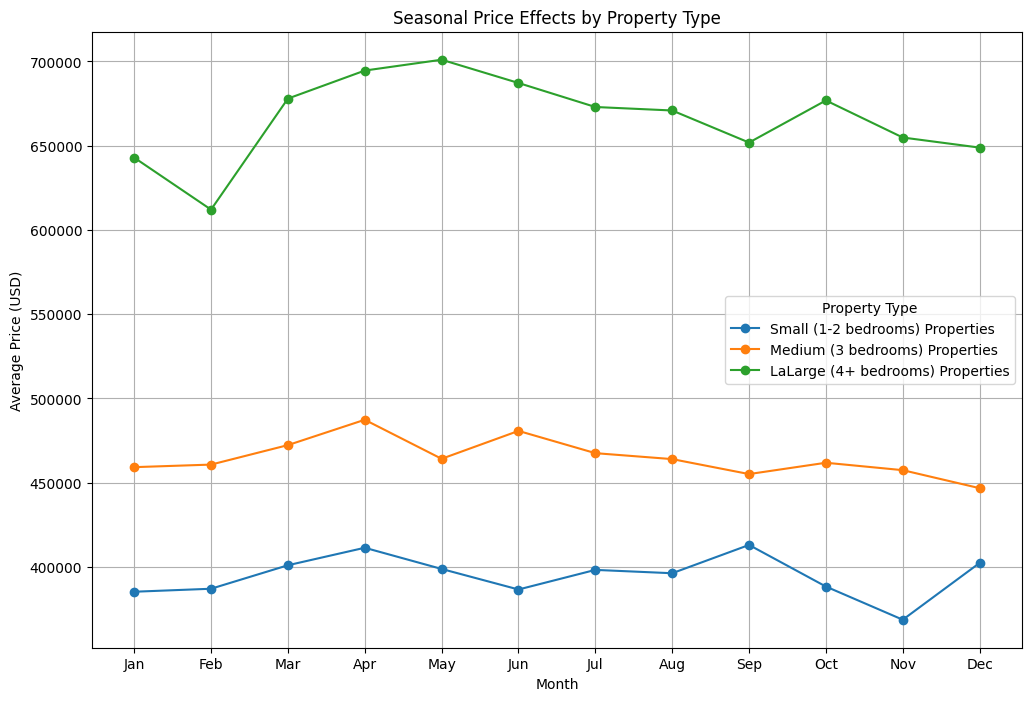

In [15]:
# Define property types based on bedroom count
# We'll categorize properties as follows:
# - Small (1-2 bedrooms)
# - Medium (3 bedrooms)
# - Large (4+ bedrooms)

data['property_type'] = pd.cut(data['bedrooms'], bins=[0, 2, 3, float('inf')], labels=['Small (1-2 bedrooms)', 'Medium (3 bedrooms)', 'LaLarge (4+ bedrooms)'])

# Calculate the monthly average price for each property type
monthly_avg_price_by_type = data.groupby(['month', 'property_type'])['price'].mean().unstack()

# Plotting monthly average price trends by property type to observe seasonal effects
plt.figure(figsize=(12, 8))
for property_type in monthly_avg_price_by_type.columns:
    plt.plot(monthly_avg_price_by_type.index, monthly_avg_price_by_type[property_type], marker='o', linestyle='-', 
             label=f"{property_type} Properties")

plt.title("Seasonal Price Effects by Property Type")
plt.xlabel("Month")
plt.ylabel("Average Price (USD)")
plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Property Type")
plt.grid(True)
plt.show()


It would be best to combine that with sqdt_living, since it is known to be the most influental factor on the price.

Lets take a look at the differences over time in our two desired areas: sadly, it forgot all the narrowing down criteria. I check, if I can combine the visualisations.

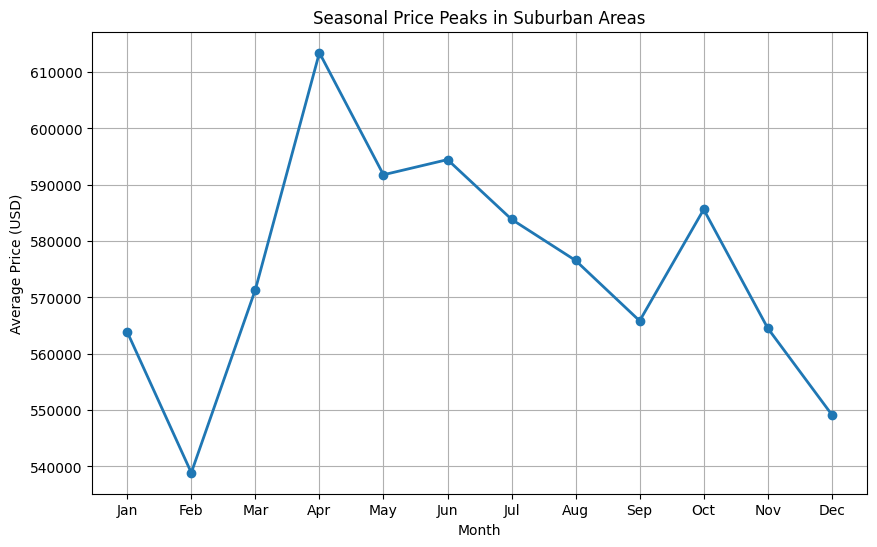

(4, 613437.2909760589)

In [9]:
# Assume suburban areas are characterized by larger lot sizes, let's set a threshold for 'suburban' properties.
# Here, we'll define "suburban" as properties in the top 50% of lot sizes (as a basic approximation).

suburb_threshold = data['sqft_lot'].quantile(0.5)
suburban_properties = data[data['sqft_lot'] >= suburb_threshold]

# Calculate the average price for suburban properties by month
monthly_avg_price_suburbs = suburban_properties.groupby('month')['price'].mean()

# Plotting the monthly average prices for suburban properties to identify seasonal price peaks
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_price_suburbs.index, monthly_avg_price_suburbs.values, marker='o', linestyle='-', linewidth=2)
plt.title("Seasonal Price Peaks in Suburban Areas")
plt.xlabel("Month")
plt.ylabel("Average Price (USD)")
plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

# Finding the peak month(s) with the highest average price for suburban areas
suburb_peak_month = monthly_avg_price_suburbs.idxmax()
suburb_peak_month_price = monthly_avg_price_suburbs.max()

suburb_peak_month, suburb_peak_month_price


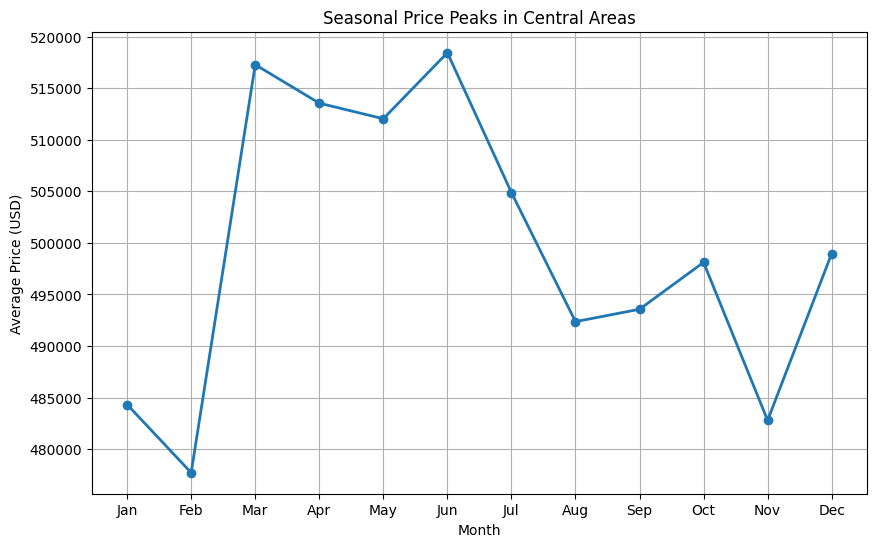

(6, 518441.54253308126)

In [10]:
# Define "central" properties as those in the bottom 50% of lot sizes (approximating central areas with smaller lots)
central_properties = data[data['sqft_lot'] < suburb_threshold]

# Calculate the average price for central properties by month
monthly_avg_price_central = central_properties.groupby('month')['price'].mean()

# Plotting the monthly average prices for central properties to identify seasonal price peaks
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_price_central.index, monthly_avg_price_central.values, marker='o', linestyle='-', linewidth=2)
plt.title("Seasonal Price Peaks in Central Areas")
plt.xlabel("Month")
plt.ylabel("Average Price (USD)")
plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

# Finding the peak month(s) with the highest average price for central areas
central_peak_month = monthly_avg_price_central.idxmax()
central_peak_month_price = monthly_avg_price_central.max()

central_peak_month, central_peak_month_price


Lets try to get more info about the distribution of those areas mapwise:

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Define centrality by normalizing sqft_living15 and inverse of sqft_lot15 as proxies for density
data['density_score'] = data['sqft_living15'] / data['sqft_lot15']

# Thresholds for "central" and "remote" areas based on density score quartiles
central_threshold = data['density_score'].quantile(0.75)  # Top 25% considered central
remote_threshold = data['density_score'].quantile(0.25)   # Bottom 25% considered remote

# Label data points as 'Central' or 'Remote' based on density thresholds
data['area_type'] = data['density_score'].apply(lambda x: 'Central' if x >= central_threshold else ('Remote' if x <= remote_threshold else 'Intermediate'))

# Filter data for plotting only central and remote areas for clarity
central_areas = data[data['area_type'] == 'Central']
remote_areas = data[data['area_type'] == 'Remote']

# Set up Basemap for Seattle
plt.figure(figsize=(12, 10))
m = Basemap(projection='merc', llcrnrlat=47.2, urcrnrlat=47.8, llcrnrlon=-122.5, urcrnrlon=-121.9, resolution='h')

# Plot central and remote points on the map
m.scatter(central_areas['long'].values, central_areas['lat'].values, latlon=True, s=10, color='red', label='Central')
m.scatter(remote_areas['long'].values, remote_areas['lat'].values, latlon=True, s=10, color='blue', label='Remote')

# Map setup with labels and grid
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgrey', lake_color='lightblue')
m.drawparallels(np.arange(47.2, 47.8, 0.1), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-122.5, -121.9, 0.1), labels=[0, 0, 0, 1])

plt.legend(title="Area Type")
plt.title("Central vs. Remote Areas in Seattle Based on Property Density")
plt.show()


OSError: Unable to open boundary dataset file. Only the 'crude', 'low' and 'intermediate' resolution datasets are installed by default. If you are requesting a 'high' or 'full' resolution dataset, you need to install the `basemap-data-hires` package

<Figure size 1200x1000 with 0 Axes>

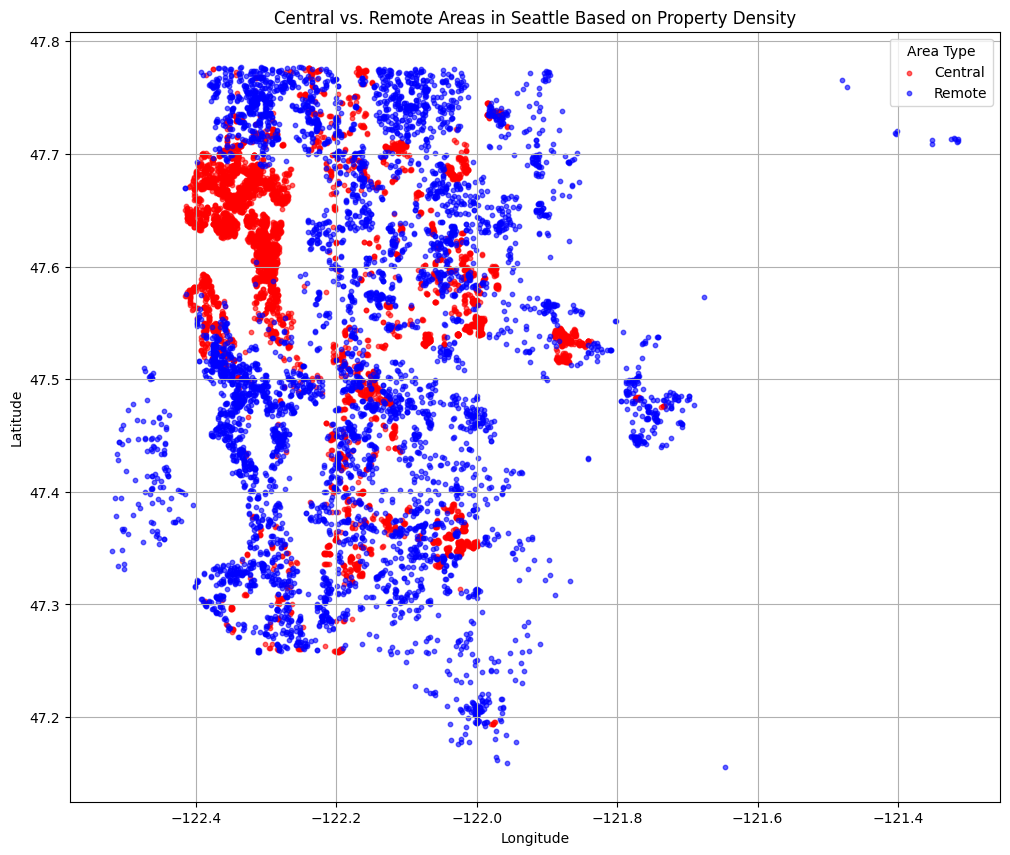

In [12]:
# Scatter plot for central and remote areas in Seattle based on property density (using lat/long coordinates)

plt.figure(figsize=(12, 10))
plt.scatter(central_areas['long'], central_areas['lat'], color='red', label='Central', s=10, alpha=0.6)
plt.scatter(remote_areas['long'], remote_areas['lat'], color='blue', label='Remote', s=10, alpha=0.6)

# Adding labels and title
plt.title("Central vs. Remote Areas in Seattle Based on Property Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Area Type")
plt.grid(True)

plt.show()


In [13]:
# Prepare data for a heatmap of recommended remote areas
import folium
from folium.plugins import HeatMap

# Filter remote properties within recommended zip codes and average price range
heatmap_data = avg_remote_properties[avg_remote_properties['zipcode'].isin(recommended_remote_zipcodes.index)]

# Extract latitude, longitude, and price for heatmap intensity
heatmap_points = heatmap_data[['lat', 'long', 'price']].values.tolist()

# Initialize a folium map centered around Seattle
seattle_map = folium.Map(location=[47.6062, -122.3321], zoom_start=10)

# Create heatmap layer, where price is used as the intensity for heat points
HeatMap(heatmap_points, min_opacity=0.4, max_opacity=0.8, radius=15, blur=15).add_to(seattle_map)

# Display the heatmap
seattle_map


NameError: name 'avg_remote_properties' is not defined

In [14]:
# Save the generated folium map as an HTML file for user access
output_path = "/mnt/data/Seattle_Remote_Areas_Heatmap.html"
seattle_map.save(output_path)

output_path


NameError: name 'seattle_map' is not defined